In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from spacy.pipeline import EntityRuler
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import time
import warnings
import random
import os

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
df_relevant = pd.read_parquet('drive/MyDrive/Photos/df_relevant.parquet', engine='pyarrow')
df_relevant.shape

(150466, 6)

In [ ]:
pd.options.display.max_colwidth = 200

In [ ]:
df_relevant[['text']].head(6)

,text
0,Artificial intelligence Caledon Citizen Members Log in Caledon Citizen Headline General Our Issues Current Issue Archived Issues Resale Homes Collections Progress Issues Current Progress Issue Pro...
1,"Civilization Call To Power 25th Anniversary Celebration - Communities, Fan Mods Ports, 4K AI Upscale, Multiplayer Server, More! - Apolyton Civilization Site or Up Logging in... Log in or user name..."
2,"AI workshop held at Temple Trees to enhance public service efficiency June 15, 2025 Toggle navigation Hot Biz Tech Videos Archive TV FM Cinema Pulse AI workshop held at Temple Trees to enhance pub..."
3,China s DeepSeek Breakthrough and What it Means for National Security Open Source Reports Analysis Africa Asia Europe Latin America Middle East North America Tech Cyber Opinion s Podcasts State Se...
4,"Colvin Ph.D. 99, LaMoreaux 01 to Discuss Impact of Artificial Intelligence on Workforce The Cornell Daily Sun Thursday, August 31 Join The Sun! The Sun 161 Things Every Cornellian Should Do our iP..."
5,How 2024 Battleground States Are Preparing for AI Election Threats Experts Open Source Reports Analysis Africa Asia Europe Latin America Middle East North America Tech Cyber Opinion s Podcasts Sta...


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 122.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Compared Various NER Models to Extract Organizations, People, and Technologies

In [ ]:
class NERComparison:
    """
    A comprehensive NER model comparison class for entity extraction
    from unstructured text data.
    """

    def __init__(self):
        self.models = {}
        self.results = {}
        self.sample_texts = None

    def load_models(self):
        """Load different NER models for comparison"""
        print("Loading NER models...")

        try:
            # 1. spaCy models
            self.models['spacy_sm'] = spacy.load("en_core_web_sm")
            print("✓ spaCy small model loaded")
        except OSError:
            print("⚠ spaCy small model not found. Install with: python -m spacy download en_core_web_sm")

        try:
            self.models['spacy_lg'] = spacy.load("en_core_web_lg")
            print("✓ spaCy large model loaded")
        except OSError:
            print("⚠ spaCy large model not found. Install with: python -m spacy download en_core_web_lg")

        try:
            # 2. Transformer-based models
            self.models['bert_ner'] = pipeline(
                "ner",
                model="dbmdz/bert-large-cased-finetuned-conll03-english",
                aggregation_strategy="simple"
            )
            print("✓ BERT NER model loaded")
        except Exception as e:
            print(f"⚠ BERT NER model failed to load: {e}")

        try:
            self.models['distilbert_ner'] = pipeline(
                "ner",
                model="Babelscape/wikineural-multilingual-ner",
                aggregation_strategy="simple"
            )
            print("✓ DistilBERT NER model loaded")
        except Exception as e:
            print(f"⚠ DistilBERT NER model failed to load: {e}")

        try:
            self.models['roberta_ner'] = pipeline(
                "ner",
                model="Jean-Baptiste/roberta-large-ner-english",
                aggregation_strategy="simple"
            )
            print("✓ RoBERTa NER model loaded")
        except Exception as e:
            print(f"⚠ RoBERTa NER model failed to load: {e}")

    def extract_entities_spacy(self, text: str, model_name: str) -> Dict[str, List[str]]:
        """Extract entities using spaCy models"""
        model = self.models[model_name]
        doc = model(text[:1000000])  # Limit text length to avoid memory issues

        entities = {
            'PERSON': [],
            'ORG': [],
            'TECHNOLOGY': []  # We'll map various tech-related labels here
        }

        for ent in doc.ents:
            if ent.label_ in ['PERSON']:
                entities['PERSON'].append(ent.text.strip())
            elif ent.label_ in ['ORG', 'ORGANIZATION']:
                entities['ORG'].append(ent.text.strip())
            elif ent.label_ in ['PRODUCT', 'GPE'] and any(tech_word in ent.text.lower()
                for tech_word in ['ai', 'artificial intelligence', 'machine learning', 'deep learning',
                                'neural', 'algorithm', 'model', 'system', 'platform', 'software']):
                entities['TECHNOLOGY'].append(ent.text.strip())

        return entities

    def extract_entities_transformer(self, text: str, model_name: str) -> Dict[str, List[str]]:
        """Extract entities using transformer-based models"""
        model = self.models[model_name]

        # Truncate text to handle model limits
        text = text[:512]  # Most transformers have 512 token limit

        try:
            results = model(text)
            entities = {
                'PERSON': [],
                'ORG': [],
                'TECHNOLOGY': []
            }

            for entity in results:
                label = entity['entity_group'] if 'entity_group' in entity else entity['entity']
                text_span = entity['word']

                if label in ['PER', 'PERSON', 'I-PER', 'B-PER']:
                    entities['PERSON'].append(text_span.strip())
                elif label in ['ORG', 'ORGANIZATION', 'I-ORG', 'B-ORG']:
                    entities['ORG'].append(text_span.strip())
                elif label in ['MISC', 'PRODUCT'] and any(tech_word in text_span.lower()
                    for tech_word in ['ai', 'artificial intelligence', 'machine learning', 'deep learning',
                                    'neural', 'algorithm', 'model', 'system', 'platform', 'software']):
                    entities['TECHNOLOGY'].append(text_span.strip())

            return entities

        except Exception as e:
            print(f"Error processing with {model_name}: {e}")
            return {'PERSON': [], 'ORG': [], 'TECHNOLOGY': []}

    def evaluate_sample_texts(self, sample_texts: List[str], sample_size: int = 100):
        """Evaluate different models on sample texts"""
        print(f"\nEvaluating models on {len(sample_texts)} sample texts...")

        self.sample_texts = sample_texts[:sample_size]
        evaluation_results = {}

        for model_name in self.models.keys():
            print(f"\nProcessing with {model_name}...")
            start_time = time.time()

            all_entities = {'PERSON': [], 'ORG': [], 'TECHNOLOGY': []}
            processing_times = []

            for i, text in enumerate(self.sample_texts):
                text_start = time.time()

                if 'spacy' in model_name:
                    entities = self.extract_entities_spacy(text, model_name)
                else:
                    entities = self.extract_entities_transformer(text, model_name)

                text_time = time.time() - text_start
                processing_times.append(text_time)

                for entity_type in all_entities:
                    all_entities[entity_type].extend(entities[entity_type])

                if (i + 1) % 20 == 0:
                    print(f"  Processed {i + 1}/{len(self.sample_texts)} texts")

            total_time = time.time() - start_time

            # Calculate metrics
            evaluation_results[model_name] = {
                'total_entities': sum(len(entities) for entities in all_entities.values()),
                'person_count': len(set(all_entities['PERSON'])),
                'org_count': len(set(all_entities['ORG'])),
                'tech_count': len(set(all_entities['TECHNOLOGY'])),
                'avg_processing_time': np.mean(processing_times),
                'total_processing_time': total_time,
                'entities_per_second': sum(len(entities) for entities in all_entities.values()) / total_time,
                'sample_entities': {
                    'PERSON': list(set(all_entities['PERSON']))[:10],
                    'ORG': list(set(all_entities['ORG']))[:10],
                    'TECHNOLOGY': list(set(all_entities['TECHNOLOGY']))[:10]
                }
            }

        self.results = evaluation_results
        return evaluation_results

    def print_comparison_report(self):
        """Print detailed comparison report"""
        if not self.results:
            print("No evaluation results available. Run evaluate_sample_texts() first.")
            return

        print("\n" + "="*80)
        print("NER MODEL COMPARISON REPORT")
        print("="*80)

        # Performance metrics table
        print(f"{'Model':<20} {'Total':<8} {'Person':<8} {'Org':<8} {'Tech':<8} {'Avg Time':<10} {'Speed':<12}")
        print("-" * 80)

        for model_name, results in self.results.items():
            print(f"{model_name:<20} "
                  f"{results['total_entities']:<8} "
                  f"{results['person_count']:<8} "
                  f"{results['org_count']:<8} "
                  f"{results['tech_count']:<8} "
                  f"{results['avg_processing_time']:.3f}s{'':<4} "
                  f"{results['entities_per_second']:.1f} ent/s")

        print("\n" + "="*80)
        print("SAMPLE ENTITIES BY MODEL")
        print("="*80)

        for model_name, results in self.results.items():
            print(f"\n{model_name.upper()}:")
            print(f"  People: {', '.join(results['sample_entities']['PERSON'][:5])}")
            print(f"  Organizations: {', '.join(results['sample_entities']['ORG'][:5])}")
            print(f"  Technologies: {', '.join(results['sample_entities']['TECHNOLOGY'][:5])}")

    def plot_comparison(self):
        """Create visualization of model comparison"""
        if not self.results:
            print("No results to plot")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        models = list(self.results.keys())

        # Entity counts
        person_counts = [self.results[m]['person_count'] for m in models]
        org_counts = [self.results[m]['org_count'] for m in models]
        tech_counts = [self.results[m]['tech_count'] for m in models]

        x = np.arange(len(models))
        width = 0.25

        ax1.bar(x - width, person_counts, width, label='Person', alpha=0.8)
        ax1.bar(x, org_counts, width, label='Organization', alpha=0.8)
        ax1.bar(x + width, tech_counts, width, label='Technology', alpha=0.8)
        ax1.set_xlabel('Models')
        ax1.set_ylabel('Unique Entity Count')
        ax1.set_title('Entity Extraction Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45)
        ax1.legend()

        # Processing time
        times = [self.results[m]['avg_processing_time'] for m in models]
        ax2.bar(models, times, alpha=0.7, color='orange')
        ax2.set_xlabel('Models')
        ax2.set_ylabel('Average Processing Time (s)')
        ax2.set_title('Processing Speed Comparison')
        plt.setp(ax2.get_xticklabels(), rotation=45)

        # Entities per second
        speeds = [self.results[m]['entities_per_second'] for m in models]
        ax3.bar(models, speeds, alpha=0.7, color='green')
        ax3.set_xlabel('Models')
        ax3.set_ylabel('Entities per Second')
        ax3.set_title('Extraction Speed (Entities/Second)')
        plt.setp(ax3.get_xticklabels(), rotation=45)

        # Total entities
        totals = [self.results[m]['total_entities'] for m in models]
        ax4.bar(models, totals, alpha=0.7, color='purple')
        ax4.set_xlabel('Models')
        ax4.set_ylabel('Total Entities Found')
        ax4.set_title('Total Entity Extraction')
        plt.setp(ax4.get_xticklabels(), rotation=45)

        plt.tight_layout()
        plt.show()

    def recommend_best_model(self):
        """Recommend the best model based on evaluation results"""
        if not self.results:
            print("No evaluation results available.")
            return None

        print("\n" + "="*60)
        print("MODEL RECOMMENDATION")
        print("="*60)

        # Calculate composite scores
        scores = {}
        for model_name, results in self.results.items():
            # Normalize metrics (higher is better for entity counts, lower is better for time)
            entity_score = (results['total_entities'] / max(r['total_entities'] for r in self.results.values())) * 40
            speed_score = (results['entities_per_second'] / max(r['entities_per_second'] for r in self.results.values())) * 30
            diversity_score = (len(set(results['sample_entities']['PERSON'] +
                                      results['sample_entities']['ORG'] +
                                      results['sample_entities']['TECHNOLOGY'])) / 30) * 30

            scores[model_name] = entity_score + speed_score + diversity_score

        # Sort by score
        ranked_models = sorted(scores.items(), key=lambda x: x[1], reverse=True)

        print(f"Ranking based on entity extraction quality, speed, and diversity:\n")
        for i, (model, score) in enumerate(ranked_models, 1):
            print(f"{i}. {model:<20} Score: {score:.1f}/100")

        best_model = ranked_models[0][0]
        print(f"\n🏆 RECOMMENDED MODEL: {best_model}")

        return best_model

In [ ]:
def run_ner_evaluation(df_relevant):
    """
    Main function to run NER evaluation on your dataset
    """
    print("Starting NER Model Evaluation...")
    print(f"Dataset size: {len(df_relevant)} rows")

    # Initialize comparison class
    ner_comp = NERComparison()

    # Load models
    ner_comp.load_models()

    if not ner_comp.models:
        print("No models loaded successfully. Please install required libraries.")
        return None

    # Sample texts for evaluation
    sample_texts = df_relevant['text'].dropna().tolist()[:200]  # Use first 200 for evaluation

    # Run evaluation
    results = ner_comp.evaluate_sample_texts(sample_texts, sample_size=100) # Select 100 sample randomly from 200 texts

    # Print results
    ner_comp.print_comparison_report()

    # Plot comparison
    ner_comp.plot_comparison()

    # Get recommendation
    best_model = ner_comp.recommend_best_model()

    return ner_comp, best_model

### Sample Testing to Find Best NER Model

Starting NER Model Evaluation...
Dataset size: 150466 rows
Loading NER models...
✓ spaCy small model loaded
✓ spaCy large model loaded


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✓ BERT NER model loaded


Device set to use cpu


✓ DistilBERT NER model loaded


Device set to use cpu


✓ RoBERTa NER model loaded

Evaluating models on 200 sample texts...

Processing with spacy_sm...
  Processed 20/100 texts
  Processed 40/100 texts
  Processed 60/100 texts
  Processed 80/100 texts
  Processed 100/100 texts

Processing with spacy_lg...
  Processed 20/100 texts
  Processed 40/100 texts
  Processed 60/100 texts
  Processed 80/100 texts
  Processed 100/100 texts

Processing with bert_ner...
  Processed 20/100 texts
  Processed 40/100 texts
  Processed 60/100 texts
  Processed 80/100 texts
  Processed 100/100 texts

Processing with distilbert_ner...
  Processed 20/100 texts
  Processed 40/100 texts
  Processed 60/100 texts
  Processed 80/100 texts
  Processed 100/100 texts

Processing with roberta_ner...
  Processed 20/100 texts
  Processed 40/100 texts
  Processed 60/100 texts
  Processed 80/100 texts
  Processed 100/100 texts

NER MODEL COMPARISON REPORT
Model                Total    Person   Org      Tech     Avg Time   Speed       
-------------------------------------

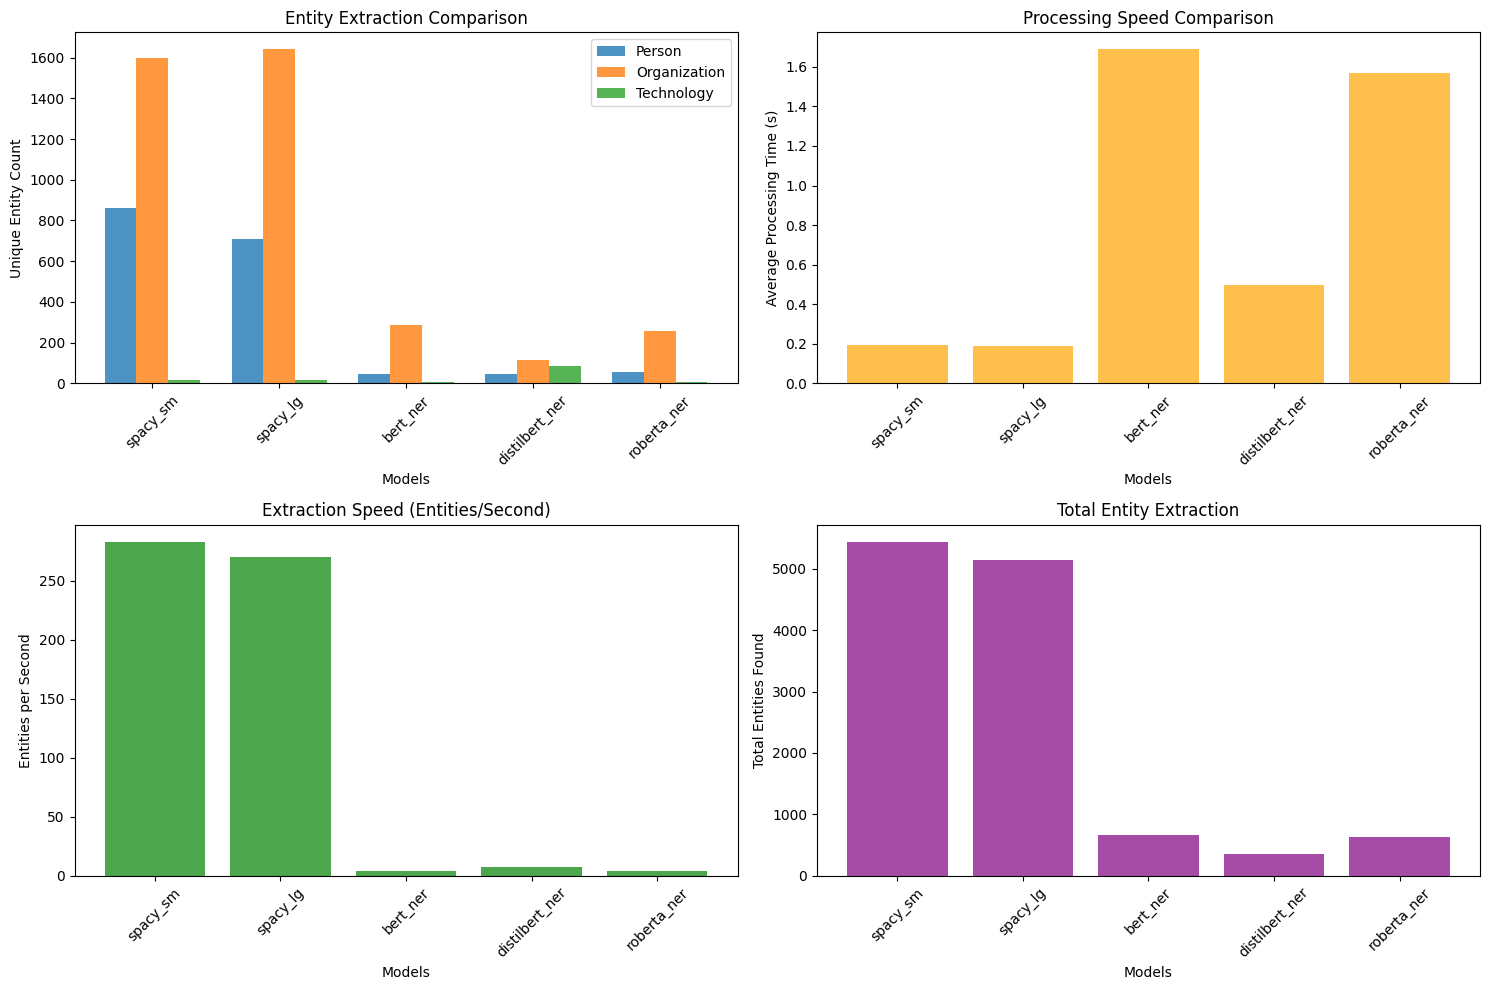


MODEL RECOMMENDATION
Ranking based on entity extraction quality, speed, and diversity:

1. spacy_sm             Score: 100.0/100
2. spacy_lg             Score: 96.4/100
3. roberta_ner          Score: 34.1/100
4. distilbert_ner       Score: 33.4/100
5. bert_ner             Score: 31.3/100

🏆 RECOMMENDED MODEL: spacy_sm


In [ ]:
# Run evaluation on sample
ner_comp, best_model = run_ner_evaluation(df_relevant)

### Conduct NER using spacy_sm

Extract people, organization, and technology entities from the full df_relevant['text'] dataset (150,000+ rows) using the en_core_web_sm SpaCy model.

In [ ]:
def extract_entities_from_full_dataset(df_relevant, model_choice='spacy_sm', test_mode=False, sample_size=100, random_seed=42, batch_size=1000):
    """
    Extract entities from the full dataset or a sample using the chosen model.

    Args:
        df_relevant (pd.DataFrame): DataFrame with 'text' column
        model_choice (str): NER model to use ('spacy_sm' or 'spacy_lg')
        test_mode (bool): If True, process only a sample of size sample_size
        sample_size (int): Number of rows to sample for testing
        random_seed (int): Random seed for reproducibility in test mode
        batch_size (int): Number of texts to process in each batch

    Returns:
        pd.DataFrame: DataFrame with extracted entities
    """
    print(f"\nExtracting entities from {'sample' if test_mode else 'full'} dataset using {model_choice}...")

    # Select data: sample or full dataset
    if test_mode:
        random.seed(random_seed)
        sample_indices = random.sample(range(len(df_relevant)), min(sample_size, len(df_relevant)))
        data = df_relevant.iloc[sample_indices].copy()
        print(f"Processing sample of {len(data)} rows")
    else:
        data = df_relevant
        print(f"Processing full dataset of {len(data)} rows")

    if model_choice.startswith('spacy'):
        nlp = spacy.load("en_core_web_sm" if model_choice == 'spacy_sm' else "en_core_web_lg")

        # Add EntityRuler for TECHNOLOGY entities
        ruler = nlp.add_pipe("entity_ruler", before="ner")
        tech_patterns = [
            {"label": "TECHNOLOGY", "pattern": [{"LOWER": tech_word}]}
            for tech_word in [
                # AI and Machine Learning
                "artificial intelligence", "machine learning", "deep learning",
                "neural network", "natural language processing", "computer vision",
                "reinforcement learning", "generative ai", "chatbot", "large language model",
                "transformer", "bert", "gpt", "tensorflow", "pytorch", "keras", "deepseek",
                "4k ai upscale",

                # Software and Platforms
                "software", "application", "app", "api", "cloud computing", "saas", "paas",
                "iaas", "operating system", "linux", "windows", "android", "ios", "middleware",
                "database", "blockchain", "distributed ledger", "serverless", "docker", "kubernetes",

                # Hardware and Devices
                "smartphone", "iphone", "ipad", "macbook", "drone", "robot", "robotics",
                "internet of things", "gpu", "tpu", "quantum computer", "chip", "microchip",
                "processor", "sensor", "wearable", "augmented reality", "virtual reality",
                "mixed reality",

                # Gaming and Multimedia
                "multiplayer server", "game engine", "unity", "unreal engine", "3d rendering",
                "ray tracing", "virtual world", "metaverse",

                # Cybersecurity and Networking
                "cybersecurity", "encryption", "firewall", "vpn", "blockchain security",
                "network protocol", "5g", "6g", "edge computing", "fog computing",

                # Data and Analytics
                "big data", "data analytics", "data science", "data warehouse", "data lake",
                "business intelligence", "predictive analytics", "machine learning model",
                "algorithm", "data pipeline",

                # Emerging Technologies
                "quantum computing", "biotechnology", "nanotechnology", "autonomous vehicle",
                "self-driving car", "digital twin", "smart contract", "web3", "cryptocurrency",
                "nft", "non-fungible token",

                # General Tech Terms
                "technology", "innovation", "digital transformation", "automation", "framework",
                "library"
            ]
        ]
        # Add single-token versions of multi-word phrases to capture variations
        tech_patterns.extend([
            {"label": "TECHNOLOGY", "pattern": [{"LOWER": word}]}
            for word in ["ai", "ml", "nlp", "llm", "ar", "vr", "mr", "iot", "bi"]
        ])
        ruler.add_patterns(tech_patterns)

        def extract_spacy(texts: List[str], indices: List[int]) -> List[Dict]:
            """Extract entities from a batch of texts using nlp.pipe"""
            entities_batch = []
            for doc, idx in zip(nlp.pipe([str(t)[:1000000] if pd.notna(t) else "" for t in texts], batch_size=100), indices):
                entities = {'PERSON': [], 'ORG': [], 'TECHNOLOGY': []}
                for ent in doc.ents:
                    if ent.label_ == 'PERSON':
                        entities['PERSON'].append(ent.text.strip())
                    elif ent.label_ == 'ORG':
                        entities['ORG'].append(ent.text.strip())
                    elif ent.label_ == 'TECHNOLOGY':
                        entities['TECHNOLOGY'].append(ent.text.strip())
                entities_batch.append((idx, entities))
            return entities_batch

        # Process texts in batches using nlp.pipe
        all_results = []
        for i in range(0, len(data), batch_size):
            batch = data.iloc[i:i+batch_size]
            batch_texts = batch['text'].tolist()
            batch_indices = batch.index.tolist()
            batch_results = extract_spacy(batch_texts, batch_indices)
            all_results.extend(batch_results)
            print(f"Processed {min(i+batch_size, len(data))}/{len(data)} rows")

        # Sort results by index to maintain order
        all_results.sort(key=lambda x: x[0])
        all_entities = [result[1] for result in all_results]
        result_indices = [result[0] for result in all_results]

        # Create DataFrame for results
        ner_results_df = pd.DataFrame({
            'entities_person': [result['PERSON'] for result in all_entities],
            'entities_org': [result['ORG'] for result in all_entities],
            'entities_tech': [result['TECHNOLOGY'] for result in all_entities]
        }, index=result_indices)

        # Print summary for test mode
        if test_mode:
            print("\nTest Mode Summary:")
            print(f"Total rows processed: {len(ner_results_df)}")
            print(f"Rows with PERSON entities: {sum(len(x) > 0 for x in ner_results_df['entities_person'])}")
            print(f"Rows with ORG entities: {sum(len(x) > 0 for x in ner_results_df['entities_org'])}")
            print(f"Rows with TECHNOLOGY entities: {sum(len(x) > 0 for x in ner_results_df['entities_tech'])}")
            print("\nSample entities (first 5 rows):")
            print(ner_results_df.head())

        # Save results to CSV
        output_file = "ner_results_sample.csv" if test_mode else "ner_results.csv"
        ner_results_df.to_csv(output_file, index=True)
        print(f"Results saved to {output_file}")

        # Provide a link to download the file
        from google.colab import files
        files.download(output_file)

        return ner_results_df

In [ ]:
ner_sample_results = extract_entities_from_full_dataset(df_relevant, model_choice='spacy_sm', test_mode=True, sample_size=200, random_seed=42)


Extracting entities from sample dataset using spacy_sm...
Processing sample of 200 rows
Processed 200/200 rows

Test Mode Summary:
Total rows processed: 200
Rows with PERSON entities: 194
Rows with ORG entities: 197
Rows with TECHNOLOGY entities: 189

Sample entities (first 5 rows):
                                                                                                                                                                                              entities_person  \
149                                                                                                               [Featured Articles CRM Across, CRM Buyer's, Recommendations, Optimizer, Insights Reporting]   
850   [Victor Teboul, Fran ais Looking, Victor Teboul, Victor Teboul's, Essays Benbaruk, Leon Caplan, Neil Debonitas, Patty Guttman, Frank, Memoriam Kamga, Malini, Roberto Mansur, Salim Rabkin, Myriam R...   
1703  [Lightbox, Close Log, Eric Fry, Eric Fry, Meet Luke Lango, Luke Lango, Palantir PL

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Conduct named-entity recognition on the full 150000 dataset
ner_results = extract_entities_from_full_dataset(df_relevant, model_choice='spacy_sm', test_mode=False)



Extracting entities from full dataset using spacy_sm...
Processing full dataset of 150466 rows
Processed 1000/150466 rows
Processed 2000/150466 rows
Processed 3000/150466 rows
Processed 4000/150466 rows
Processed 5000/150466 rows
Processed 6000/150466 rows
Processed 7000/150466 rows
Processed 8000/150466 rows
Processed 9000/150466 rows
Processed 10000/150466 rows
Processed 11000/150466 rows
Processed 12000/150466 rows
Processed 13000/150466 rows
Processed 14000/150466 rows
Processed 15000/150466 rows
Processed 16000/150466 rows
Processed 17000/150466 rows
Processed 18000/150466 rows
Processed 19000/150466 rows
Processed 20000/150466 rows
Processed 21000/150466 rows
Processed 22000/150466 rows
Processed 23000/150466 rows
Processed 24000/150466 rows
Processed 25000/150466 rows
Processed 26000/150466 rows
Processed 27000/150466 rows
Processed 28000/150466 rows
Processed 29000/150466 rows
Processed 30000/150466 rows
Processed 31000/150466 rows
Processed 32000/150466 rows
Processed 33000/1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Entity Resolution

In [ ]:
!pip install fuzzywuzzy -q

In [ ]:
!pip install python-Levenshtein -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import re
from difflib import SequenceMatcher
from fuzzywuzzy import fuzz, process
import json
from typing import Dict, List, Set, Tuple
import ast
import time
from tqdm import tqdm
import multiprocessing as mp
from functools import partial
import gc
import psutil

In [ ]:
ner_results = pd.read_csv('drive/MyDrive/NLP/ner_results.csv')
ner_results.shape

(150466, 4)

In [ ]:
ner_results.rename(columns={ner_results.columns[0]: 'article_index'}, inplace=True)
display(ner_results.head(10))

,article_index,entities_person,entities_org,entities_tech
0,0,"['Grandma', 'Joey', 'Isaac Asimov', 'Danger Wi...","['the Blame Game Scheduling', 'the Caledon Cav...","['robot', 'robot', 'robot', 'AI', 'AI', 'AI', ..."
1,1,"['Multiplayer Server', 'List Calendar', 'https...","['Celebration - Communities', 'Fan Mods Ports'...","['AI', 'AI', 'AI', 'AI', 'AI', 'ai']"
2,2,"['Hans Wijesuriya', 'Sanjaya Karunaseena', 'Ha...","['Temple Trees', 'the Digital Economy', 'the I...","['AI', 'AI', 'AI', 'AI']"
3,3,"['Breakthrough', 'edIn X', 'Breakthrough', 'Bi...","['Pin 0 s', 'the White House', 'the U.S.', 'AN...","['DeepSeek', 'DeepSeek', 'AI', 'AI', 'DeepSeek..."
4,4,"['Colvin Ph.D.', 'Alex Colvin', 'Colvin Ph.D.'...","['The Cornell Daily Sun', 'Men s Hockey Women'...","['iPhone', 'App', 'iPhone', 'App', 'iPhone', '..."
5,5,"['edIn X', 'Photo Pin 0 s', 'Lays Out', 'Abiza...","['Sanbornton Old Town Hall', 'NH', 'Tech ANALY...","['AI', 'AI', 'AI', 'AI', 'Software']"
6,6,"['Lionel Levine', 'Levine', 'Levine', 'Leaderb...","['Kubinec Dear Professors Stop Banning', 'The ...","['iPhone', 'App', 'iPhone', 'App', 'iPhone', '..."
7,7,"['Sri Lanka', 'gazette draft', 'Rohan Premarat...","['the Cabinet of Ministers', 'the Ministry of ...","['AI', 'AI', 'AI', 'AI']"
8,8,"['Cloud Azimut Magellano', 'Azimut', 'Fabio Fr...","['Marine North America Marine', 'World North A...","['innovation', 'innovation', 'app', 'AI', 'inn..."
9,9,"['Articles Harness', 'Articles', 'Related Thro...",['International Cement Review All Blog Confere...,"['AI', 'Database', 'AI', 'AI', 'AI', 'AI', 'AI']"


In [ ]:
class OptimizedEntityResolver:
    """
    Optimized Entity Resolution class for large-scale entity normalization
    with performance enhancements for datasets with 150K+ rows and 400K+ entities.
    """

    def __init__(self, n_workers=None):
        self.entity_mappings = {
            'entities_person': {},
            'entities_org': {},
            'entities_tech': {}
        }

        # Use available CPU cores, leave 1 core free
        self.n_workers = n_workers or max(1, mp.cpu_count() - 1)

        # OPTIMIZED: Pre-compiled regex patterns for performance
        self.cleanup_patterns = {
            'whitespace': re.compile(r'\s+'),
            'prefix': re.compile(r'^(the|The)\s+'),
            'suffix': re.compile(r'[.,;:!?]+$'),
            'special_chars': re.compile(r'[^\w\s\-]')
        }

        # OPTIMIZED: Predefined mappings with normalized keys for O(1) lookup
        self.predefined_mappings = {
            'entities_tech': {
                'ai': 'Artificial Intelligence',
                'artificial intelligence': 'Artificial Intelligence',
                'machine learning': 'Machine Learning',
                'ml': 'Machine Learning',
                'deep learning': 'Deep Learning',
                'dl': 'Deep Learning',
                'nlp': 'Natural Language Processing',
                'natural language processing': 'Natural Language Processing',
                'iot': 'Internet of Things',
                'internet of things': 'Internet of Things',
                'vr': 'Virtual Reality',
                'virtual reality': 'Virtual Reality',
                'ar': 'Augmented Reality',
                'augmented reality': 'Augmented Reality',
                'gcp': 'Google Cloud Platform',
                'google cloud': 'Google Cloud Platform',
                'google cloud platform': 'Google Cloud Platform',
                'aws': 'Amazon Web Services',
                'amazon web services': 'Amazon Web Services',
                'deepseek': 'DeepSeek',
                'chatgpt': 'ChatGPT',
                'gpt': 'GPT',
                'iphone': 'iPhone',
                'app': 'Mobile Application',
                'mobile application': 'Mobile Application',
                'software': 'Software',
                'database': 'Database',
                'cybersecurity': 'Cybersecurity',
                'robot': 'Robot',
                'robotics': 'Robotics'
            },
            'entities_org': {
                'google cloud': 'Google Cloud Platform',
                'gcp': 'Google Cloud Platform',
                'google cloud platform': 'Google Cloud Platform',
                'the cornell daily sun': 'Cornell Daily Sun',
                'cornell daily sun': 'Cornell Daily Sun',
                'temple trees': 'Temple Trees',
                'icta': 'Information and Communication Technology Agency',
                'pmd': 'PMD',
                'boeing': 'Boeing',
                'air india': 'Air India',
                'tiktok': 'TikTok'
            },
            'entities_person': {
                'colvin': 'Alex Colvin',
                'alex colvin': 'Alex Colvin',
                'biden': 'Joe Biden',
                'joe biden': 'Joe Biden',
                'trump': 'Donald Trump',
                'donald trump': 'Donald Trump'
            }
        }

    def get_memory_usage(self):
        """Get current memory usage"""
        process = psutil.Process()
        return process.memory_info().rss / 1024 / 1024  # MB

    def clean_entity_optimized(self, entity: str) -> str:
        """OPTIMIZED: Fast entity cleaning using pre-compiled patterns"""
        if not isinstance(entity, str) or not entity.strip():
            return ""

        # Use pre-compiled patterns for faster processing
        entity = self.cleanup_patterns['whitespace'].sub(' ', entity).strip()
        entity = self.cleanup_patterns['prefix'].sub('', entity)
        entity = self.cleanup_patterns['suffix'].sub('', entity)

        return entity

    def parse_entity_list_vectorized(self, entity_series):
        """OPTIMIZED: Vectorized entity list parsing"""
        def safe_parse(entity_str):
            try:
                if isinstance(entity_str, str):
                    return ast.literal_eval(entity_str)
                elif isinstance(entity_str, list):
                    return entity_str
                else:
                    return []
            except:
                return []

        return entity_series.apply(safe_parse)

    def fast_similarity_check(self, s1: str, s2: str, threshold: float = 0.85) -> bool:
        """OPTIMIZED: Fast similarity check with early termination"""
        s1_clean = s1.lower().strip()
        s2_clean = s2.lower().strip()

        if s1_clean == s2_clean:
            return True

        # Quick length check for early termination
        len_ratio = min(len(s1_clean), len(s2_clean)) / max(len(s1_clean), len(s2_clean))
        if len_ratio < 0.3:  # Very different lengths unlikely to be similar
            return False

        # Check abbreviation first (fastest)
        if self.is_abbreviation(s1_clean, s2_clean):
            return True

        # Only do expensive fuzzy matching if quick checks don't eliminate
        ratio = fuzz.token_set_ratio(s1_clean, s2_clean) / 100
        return ratio >= threshold

    def is_abbreviation(self, short: str, long: str) -> bool:
        """OPTIMIZED: Fast abbreviation detection"""
        if len(short) > len(long):
            short, long = long, short

        if len(short) <= 5 and len(long) > len(short):
            words = long.split()
            if len(words) > 1:
                abbrev = ''.join([word[0].lower() for word in words if word])
                return abbrev == short.lower()

        return False

    def cluster_entities_optimized(self, entities: List[str], similarity_threshold: float = 0.85) -> Dict[str, str]:
        """OPTIMIZED: Fast entity clustering with reduced complexity"""
        if not entities:
            return {}

        # OPTIMIZED: Pre-clean all entities
        entity_pairs = [(self.clean_entity_optimized(entity), entity) for entity in entities if entity.strip()]
        unique_pairs = list(set(entity_pairs))  # Remove exact duplicates early

        if len(unique_pairs) <= 1:
            return {pair[1]: pair[1] for pair in unique_pairs}

        print(f"    Clustering {len(unique_pairs)} unique entities...")

        # OPTIMIZED: Use frequency-based approach for large datasets
        entity_freq = Counter([pair[0] for pair in unique_pairs])
        sorted_entities = sorted(unique_pairs, key=lambda x: entity_freq[x[0]], reverse=True)

        mapping = {}
        processed = set()

        # OPTIMIZED: Process most frequent entities first
        with tqdm(total=len(sorted_entities), desc="    Clustering", leave=False) as pbar:
            for cleaned, original in sorted_entities:
                if original in processed:
                    pbar.update(1)
                    continue

                # Use this entity as canonical form
                canonical = original
                mapping[original] = canonical
                processed.add(original)

                # OPTIMIZED: Only check remaining unprocessed entities
                remaining = [(c, o) for c, o in sorted_entities if o not in processed]

                # OPTIMIZED: Limit similarity checks for very large clusters
                check_limit = min(500, len(remaining))  # Limit expensive operations

                for other_cleaned, other_original in remaining[:check_limit]:
                    if self.fast_similarity_check(cleaned, other_cleaned, similarity_threshold):
                        mapping[other_original] = canonical
                        processed.add(other_original)

                pbar.update(1)

        return mapping

    def apply_predefined_mappings_vectorized(self, entities: List[str], entity_type: str) -> List[str]:
        """OPTIMIZED: Vectorized predefined mapping application"""
        if entity_type not in self.predefined_mappings:
            return entities

        mappings = self.predefined_mappings[entity_type]

        # OPTIMIZED: Batch process with list comprehension
        return [mappings.get(self.clean_entity_optimized(entity).lower(),
                           self.clean_entity_optimized(entity)) for entity in entities]

    def process_entity_column_chunked(self, df: pd.DataFrame, col: str,
                                    similarity_threshold: float = 0.85,
                                    chunk_size: int = 10000) -> Tuple[List[List], Dict]:
        """OPTIMIZED: Process entity column in chunks to manage memory"""
        print(f"  Collecting and processing entities from {len(df):,} rows...")

        # OPTIMIZED: Vectorized entity parsing
        entity_series = self.parse_entity_list_vectorized(df[col])

        # OPTIMIZED: Flatten entities efficiently
        all_entities = []
        entity_counts = []

        with tqdm(total=len(df), desc="  Collecting entities", leave=False) as pbar:
            for entities_list in entity_series:
                if entities_list:
                    all_entities.extend(entities_list)
                    entity_counts.append(len(entities_list))
                else:
                    entity_counts.append(0)
                pbar.update(1)

        print(f"  Collected {len(all_entities):,} total entities")

        # OPTIMIZED: Get unique entities with frequency counting
        unique_entities = list(set([entity for entity in all_entities if entity and entity.strip()]))
        print(f"  Found {len(unique_entities):,} unique entities")

        # Memory cleanup
        del all_entities
        gc.collect()

        # Apply predefined mappings
        print(f"  Applying predefined mappings...")
        predefined_resolved = self.apply_predefined_mappings_vectorized(unique_entities, col)

        # OPTIMIZED: Skip clustering if too many entities (>10000), use frequency-based approach instead
        if len(unique_entities) > 10000:
            print(f"  Large entity set detected ({len(unique_entities):,}). Using frequency-based resolution...")
            entity_mapping = self.frequency_based_resolution(predefined_resolved)
        else:
            print(f"  Finding entity clusters...")
            entity_mapping = self.cluster_entities_optimized(predefined_resolved, similarity_threshold)

        # OPTIMIZED: Apply resolution in chunks to manage memory
        print(f"  Applying resolution to all rows...")
        resolved_entities_list = []

        chunk_start = 0
        while chunk_start < len(df):
            chunk_end = min(chunk_start + chunk_size, len(df))
            chunk_series = entity_series.iloc[chunk_start:chunk_end]

            chunk_resolved = []
            with tqdm(total=len(chunk_series), desc=f"  Chunk {chunk_start//chunk_size + 1}", leave=False) as pbar:
                for entities_list in chunk_series:
                    if entities_list:
                        # Apply predefined mappings
                        predefined_resolved_entities = self.apply_predefined_mappings_vectorized(entities_list, col)

                        # Apply cluster mappings
                        resolved_entities = [
                            entity_mapping.get(entity, entity) for entity in predefined_resolved_entities
                        ]

                        # OPTIMIZED: Fast deduplication while preserving order
                        final_entities = list(dict.fromkeys([e for e in resolved_entities if e and e.strip()]))
                    else:
                        final_entities = []

                    chunk_resolved.append(final_entities)
                    pbar.update(1)

            resolved_entities_list.extend(chunk_resolved)
            chunk_start = chunk_end

            # Memory cleanup between chunks
            gc.collect()

        return resolved_entities_list, entity_mapping

    def frequency_based_resolution(self, entities: List[str]) -> Dict[str, str]:
        """OPTIMIZED: Frequency-based resolution for very large entity sets"""
        print("    Using frequency-based resolution for large entity set...")

        # Count entity frequencies
        entity_freq = Counter([self.clean_entity_optimized(e) for e in entities])

        # Use most frequent form as canonical
        mapping = {}
        for entity in entities:
            cleaned = self.clean_entity_optimized(entity)
            # Map to the most frequent version of this cleaned entity
            mapping[entity] = cleaned

        return mapping

    def resolve_entities_in_dataframe(self, df: pd.DataFrame,
                                     similarity_threshold: float = 0.85,
                                     chunk_size: int = 10000) -> pd.DataFrame:
        """OPTIMIZED: Resolve entities with memory management and chunked processing"""
        print("Starting optimized entity resolution...")
        print(f"Dataset size: {len(df):,} rows")
        print(f"Using {self.n_workers} worker processes")
        print(f"Memory usage: {self.get_memory_usage():.1f} MB")

        start_time = time.time()
        resolved_df = df.copy()

        entity_columns = ['entities_person', 'entities_org', 'entities_tech']

        # Calculate total steps for progress estimation
        total_steps = len([col for col in entity_columns if col in df.columns])
        current_step = 0

        for col in entity_columns:
            if col not in df.columns:
                continue

            current_step += 1
            step_start_time = time.time()

            print(f"\n[Step {current_step}/{total_steps}] Processing {col}...")
            print(f"Memory usage: {self.get_memory_usage():.1f} MB")

            # OPTIMIZED: Process column in chunks
            resolved_entities_list, entity_mapping = self.process_entity_column_chunked(
                df, col, similarity_threshold, chunk_size
            )

            # Store mapping for later reference
            self.entity_mappings[col] = entity_mapping

            # Add resolved column to dataframe
            resolved_df[col + '_resolved'] = resolved_entities_list

            # OPTIMIZED: Memory cleanup and progress reporting
            gc.collect()
            step_time = time.time() - step_start_time
            elapsed_total = time.time() - start_time

            print(f"  ✓ Created {len(entity_mapping):,} entity mappings")

            if current_step < total_steps:
                avg_step_time = elapsed_total / current_step
                remaining_steps = total_steps - current_step
                eta = remaining_steps * avg_step_time
                print(f"  ✓ Step completed in {step_time:.1f}s | ETA: {eta:.1f}s ({eta/60:.1f}m)")
            else:
                print(f"  ✓ Step completed in {step_time:.1f}s")

        total_time = time.time() - start_time
        print(f"\n🎉 Entity resolution completed in {total_time:.1f}s ({total_time/60:.1f}m)")
        print(f"Final memory usage: {self.get_memory_usage():.1f} MB")

        return resolved_df

    def clean_entity_optimized(self, entity: str) -> str:
        """OPTIMIZED: Fast entity cleaning using pre-compiled patterns"""
        if not isinstance(entity, str) or not entity.strip():
            return ""

        # Use pre-compiled patterns for faster processing
        entity = self.cleanup_patterns['whitespace'].sub(' ', entity).strip()
        entity = self.cleanup_patterns['prefix'].sub('', entity)
        entity = self.cleanup_patterns['suffix'].sub('', entity)

        return entity

    def parse_entity_list_vectorized(self, entity_series):
        """OPTIMIZED: Vectorized entity list parsing"""
        def safe_parse(entity_str):
            try:
                if isinstance(entity_str, str):
                    return ast.literal_eval(entity_str)
                elif isinstance(entity_str, list):
                    return entity_str
                else:
                    return []
            except:
                return []

        return entity_series.apply(safe_parse)

    def fast_similarity_check(self, s1: str, s2: str, threshold: float = 0.85) -> bool:
        """OPTIMIZED: Fast similarity check with early termination"""
        s1_clean = s1.lower().strip()
        s2_clean = s2.lower().strip()

        if s1_clean == s2_clean:
            return True

        # Quick length check for early termination
        len_ratio = min(len(s1_clean), len(s2_clean)) / max(len(s1_clean), len(s2_clean))
        if len_ratio < 0.3:  # Very different lengths unlikely to be similar
            return False

        # Check abbreviation first (fastest)
        if self.is_abbreviation(s1_clean, s2_clean):
            return True

        # Only do expensive fuzzy matching if quick checks don't eliminate
        ratio = fuzz.token_set_ratio(s1_clean, s2_clean) / 100
        return ratio >= threshold

    def is_abbreviation(self, short: str, long: str) -> bool:
        """OPTIMIZED: Fast abbreviation detection"""
        if len(short) > len(long):
            short, long = long, short

        if len(short) <= 5 and len(long) > len(short):
            words = long.split()
            if len(words) > 1:
                abbrev = ''.join([word[0].lower() for word in words if word])
                return abbrev == short.lower()

        return False

    def apply_predefined_mappings_vectorized(self, entities: List[str], entity_type: str) -> List[str]:
        """OPTIMIZED: Vectorized predefined mapping application"""
        if entity_type not in self.predefined_mappings:
            return entities

        mappings = self.predefined_mappings[entity_type]

        # OPTIMIZED: Batch process with list comprehension
        return [mappings.get(self.clean_entity_optimized(entity).lower(),
                           self.clean_entity_optimized(entity)) for entity in entities]

    def get_resolution_statistics(self, original_df: pd.DataFrame, resolved_df: pd.DataFrame):
        """Generate statistics about the entity resolution process"""
        stats = {}

        entity_columns = ['entities_person', 'entities_org', 'entities_tech']

        for col in entity_columns:
            if col not in original_df.columns:
                continue

            # OPTIMIZED: Vectorized entity counting
            original_series = self.parse_entity_list_vectorized(original_df[col])
            original_entities = [entity for entities_list in original_series for entity in entities_list if entity and entity.strip()]

            resolved_col = col + '_resolved'
            if resolved_col in resolved_df.columns:
                resolved_entities = [entity for entities_list in resolved_df[resolved_col] for entity in entities_list if entity and entity.strip()]
            else:
                resolved_entities = original_entities

            original_unique = len(set(original_entities))
            resolved_unique = len(set(resolved_entities))

            stats[col] = {
                'original_total': len(original_entities),
                'original_unique': original_unique,
                'resolved_total': len(resolved_entities),
                'resolved_unique': resolved_unique,
                'reduction_rate': f"{((original_unique - resolved_unique) / original_unique * 100):.1f}%" if original_unique > 0 else "0%",
                'mappings_created': len(self.entity_mappings.get(col, {}))
            }

        return stats

    def print_resolution_report(self, stats: dict):
        """Print detailed entity resolution report"""
        print("\n" + "="*80)
        print("ENTITY RESOLUTION REPORT")
        print("="*80)

        print(f"{'Entity Type':<15} {'Orig Total':<12} {'Orig Unique':<12} {'Resolved':<12} {'Reduction':<12} {'Mappings':<10}")
        print("-" * 80)

        for entity_type, stat in stats.items():
            entity_name = entity_type.replace('entities_', '').title()
            print(f"{entity_name:<15} "
                  f"{stat['original_total']:<12,} "
                  f"{stat['original_unique']:<12,} "
                  f"{stat['resolved_unique']:<12,} "
                  f"{stat['reduction_rate']:<12} "
                  f"{stat['mappings_created']:<10,}")

    def show_sample_mappings(self, n_samples: int = 10):
        """Show sample entity mappings for each type"""
        print("\n" + "="*80)
        print("SAMPLE ENTITY MAPPINGS")
        print("="*80)

        for entity_type, mappings in self.entity_mappings.items():
            if not mappings:
                continue

            print(f"\n{entity_type.replace('entities_', '').title()} Mappings:")
            print("-" * 40)

            # Group by canonical form
            canonical_groups = defaultdict(list)
            for original, canonical in mappings.items():
                if original != canonical:  # Only show actual mappings
                    canonical_groups[canonical].append(original)

            count = 0
            for canonical, variations in canonical_groups.items():
                if count >= n_samples:
                    break
                if len(variations) > 1:  # Only show where multiple entities map to one
                    print(f"  {canonical} <- {variations[:5]}")  # Show max 5 variations
                    count += 1

    def save_mappings(self, filepath: str):
        """Save entity mappings to JSON file"""
        with open(filepath, 'w') as f:
            json.dump(self.entity_mappings, f, indent=2)
        print(f"Entity mappings saved to {filepath}")

    def load_mappings(self, filepath: str):
        """Load entity mappings from JSON file"""
        with open(filepath, 'r') as f:
            self.entity_mappings = json.load(f)
        print(f"Entity mappings loaded from {filepath}")

    def get_memory_usage(self):
        """Get current memory usage"""
        try:
            process = psutil.Process()
            return process.memory_info().rss / 1024 / 1024  # MB
        except:
            return 0

In [ ]:
def perform_optimized_entity_resolution(df, similarity_threshold=0.85, chunk_size=10000):
    """
    OPTIMIZED: Main function to perform entity resolution on large NER results dataframe

    Parameters:
    df: DataFrame with columns [article_index, entities_person, entities_org, entities_tech]
    similarity_threshold: Threshold for entity similarity (0.0 to 1.0)
    chunk_size: Size of chunks for processing (adjust based on memory)

    Returns:
    resolved_df: DataFrame with additional resolved entity columns
    resolver: EntityResolver object for further analysis
    """

    overall_start_time = time.time()

    print("🚀 OPTIMIZED ENTITY RESOLUTION")
    print("=" * 60)
    print(f"Processing {len(df):,} rows")
    print(f"Similarity threshold: {similarity_threshold}")
    print(f"Chunk size: {chunk_size:,}")
    print(f"Available CPU cores: {mp.cpu_count()}")

    resolver = OptimizedEntityResolver()
    print(f"Initial memory usage: {resolver.get_memory_usage():.1f} MB")

    # Perform entity resolution
    resolved_df = resolver.resolve_entities_in_dataframe(df, similarity_threshold, chunk_size)

    # Generate statistics
    print("\nGenerating resolution statistics...")
    stats = resolver.get_resolution_statistics(df, resolved_df)

    # Print reports
    resolver.print_resolution_report(stats)
    resolver.show_sample_mappings()

    # Final summary
    total_execution_time = time.time() - overall_start_time
    print(f"\n{'='*60}")
    print(f"EXECUTION SUMMARY")
    print(f"{'='*60}")
    print(f"Total execution time: {total_execution_time:.1f}s ({total_execution_time/60:.1f}m)")
    print(f"Rows processed: {len(df):,}")
    print(f"Processing rate: {len(df)/total_execution_time:.1f} rows/second")
    print(f"Peak memory usage: {resolver.get_memory_usage():.1f} MB")

    return resolved_df, resolver

In [ ]:
# Example usage
def main():
    # Sample data structure like yours
    sample_data = {
        'article_index': [0, 1, 2, 3],
        'entities_person': [
            ['Trump', 'Biden', 'Alex Colvin'],
            ['Colvin', 'trump'],
            ['Hans Wijesuriya', 'biden'],
            ['Donald Trump', 'Joe Biden']
        ],
        'entities_org': [
            ['Google Cloud', 'Cornell Daily Sun'],
            ['GCP', 'The Cornell Daily Sun'],
            ['Google Cloud Platform', 'Cornell Daily Sun'],
            ['Temple Trees', 'ICTA']
        ],
        'entities_tech': [
            ['AI', 'machine learning', 'iPhone'],
            ['Artificial Intelligence', 'ML', 'app'],
            ['artificial intelligence', 'Machine Learning', 'mobile application'],
            ['DeepSeek', 'AI', 'Software']
        ]
    }

    df = pd.DataFrame(sample_data)
    print("Original DataFrame:")
    print(df)

    # Perform entity resolution
    resolved_df, resolver = perform_optimized_entity_resolution(df, similarity_threshold=0.8)

    print("\nResolved DataFrame:")
    print(resolved_df[['article_index', 'entities_person_resolved', 'entities_org_resolved', 'entities_tech_resolved']])

if __name__ == "__main__":
    main()

Original DataFrame:
   article_index              entities_person  \
0              0  [Trump, Biden, Alex Colvin]   
1              1              [Colvin, trump]   
2              2     [Hans Wijesuriya, biden]   
3              3    [Donald Trump, Joe Biden]   

                                 entities_org  \
0           [Google Cloud, Cornell Daily Sun]   
1                [GCP, The Cornell Daily Sun]   
2  [Google Cloud Platform, Cornell Daily Sun]   
3                        [Temple Trees, ICTA]   

                                       entities_tech  
0                     [AI, machine learning, iPhone]  
1                 [Artificial Intelligence, ML, app]  
2  [artificial intelligence, Machine Learning, mo...  
3                           [DeepSeek, AI, Software]  
🚀 OPTIMIZED ENTITY RESOLUTION
Processing 4 rows
Similarity threshold: 0.8
Chunk size: 10,000
Available CPU cores: 12
Initial memory usage: 379.4 MB
Starting optimized entity resolution...
Dataset size: 4 rows
Usin

  Collected 9 total entities
  Found 9 unique entities
  Applying predefined mappings...
  Finding entity clusters...
    Clustering 4 unique entities...


  Applying resolution to all rows...


  ✓ Created 4 entity mappings
  ✓ Step completed in 0.1s | ETA: 0.2s (0.0m)

[Step 2/3] Processing entities_org...
Memory usage: 379.6 MB


  Collected 8 total entities
  Found 7 unique entities
  Applying predefined mappings...
  Finding entity clusters...
    Clustering 4 unique entities...


  Applying resolution to all rows...


  ✓ Created 4 entity mappings
  ✓ Step completed in 0.1s | ETA: 0.1s (0.0m)

[Step 3/3] Processing entities_tech...


Memory usage: 379.6 MB


  Collected 12 total entities
  Found 11 unique entities
  Applying predefined mappings...
  Finding entity clusters...
    Clustering 6 unique entities...


  Applying resolution to all rows...


  ✓ Created 6 entity mappings
  ✓ Step completed in 0.1s

🎉 Entity resolution completed in 0.3s (0.0m)
Final memory usage: 379.6 MB

Generating resolution statistics...

ENTITY RESOLUTION REPORT
Entity Type     Orig Total   Orig Unique  Resolved     Reduction    Mappings  
--------------------------------------------------------------------------------
Person          9            9            4            55.6%        4         
Org             8            7            4            42.9%        4         
Tech            12           11           6            45.5%        6         

SAMPLE ENTITY MAPPINGS

Person Mappings:
----------------------------------------

Org Mappings:
----------------------------------------

Tech Mappings:
----------------------------------------

EXECUTION SUMMARY
Total execution time: 0.3s (0.0m)
Rows processed: 4
Processing rate: 12.4 rows/second
Peak memory usage: 379.6 MB

Resolved DataFrame:
   article_index                entities_person_resolved  

In [ ]:
# Perform entity resolution
resolved_df, resolver = perform_optimized_entity_resolution(ner_results, similarity_threshold=0.85)

# Save mappings for future use
resolver.save_mappings('entity_mappings.json')

# Save the resolved DataFrame to a CSV file
resolved_df.to_csv('resolved_entities.csv', index=False)

# Provide a link to download the file
from google.colab import files
files.download('resolved_entities.csv')

🚀 OPTIMIZED ENTITY RESOLUTION
Processing 150,466 rows
Similarity threshold: 0.85
Chunk size: 10,000
Available CPU cores: 12
Initial memory usage: 379.6 MB
Starting optimized entity resolution...
Dataset size: 150,466 rows
Using 11 worker processes
Memory usage: 379.6 MB

[Step 1/3] Processing entities_person...
Memory usage: 381.2 MB


  Collected 2,447,580 total entities
  Found 477,798 unique entities
  Applying predefined mappings...
  Large entity set detected (477,798). Using frequency-based resolution...
    Using frequency-based resolution for large entity set...
  Applying resolution to all rows...


  ✓ Created 477,017 entity mappings
  ✓ Step completed in 25.0s | ETA: 49.9s (0.8m)

[Step 2/3] Processing entities_org...
Memory usage: 713.8 MB


  Collected 4,579,548 total entities
  Found 877,348 unique entities
  Applying predefined mappings...
  Large entity set detected (877,348). Using frequency-based resolution...
    Using frequency-based resolution for large entity set...
  Applying resolution to all rows...


  ✓ Created 859,931 entity mappings
  ✓ Step completed in 53.2s | ETA: 39.1s (0.7m)

[Step 3/3] Processing entities_tech...
Memory usage: 1142.9 MB


  Collected 2,445,108 total entities
  Found 226 unique entities
  Applying predefined mappings...
  Finding entity clusters...
    Clustering 183 unique entities...


  Applying resolution to all rows...


  ✓ Created 183 entity mappings
  ✓ Step completed in 18.7s

🎉 Entity resolution completed in 96.8s (1.6m)
Final memory usage: 1159.4 MB

Generating resolution statistics...

ENTITY RESOLUTION REPORT
Entity Type     Orig Total   Orig Unique  Resolved     Reduction    Mappings  
--------------------------------------------------------------------------------
Person          2,447,580    477,798      477,006      0.2%         477,017   
Org             4,579,548    877,348      859,781      2.0%         859,931   
Tech            2,445,108    226          65           71.2%        183       

SAMPLE ENTITY MAPPINGS

Person Mappings:
----------------------------------------

Org Mappings:
----------------------------------------

Tech Mappings:
----------------------------------------
  Sensor <- ['SENSOR', 'sensor']
  Chip <- ['chip', 'ChIP', 'CHIP']
  IOS <- ['ios', 'iOS', 'iOs', 'IoS', 'Ios']
  IPad <- ['Ipad', 'ipad', 'iPad', 'IPAD']
  TPU <- ['tpu', 'Tpu']
  CryptoCurrency <- ['CRYPT

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
resolved_df.shape

(150466, 7)

## Visualize Resolved Entities

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from wordcloud import WordCloud

In [ ]:
pd.options.display.max_colwidth = 200

In [ ]:
resolved_entities = pd.read_csv('drive/MyDrive/NLP/resolved_entities.csv')

In [ ]:
resolved_df = resolved_entities[['entities_person_resolved','entities_org_resolved','entities_tech_resolved']].copy()

In [ ]:
resolved_df.head()

,entities_person_resolved,entities_org_resolved,entities_tech_resolved
0,"['Grandma', 'Joey', 'Isaac Asimov', 'Danger Will Robinson', 'Artificial Intelligence', 'Opens', 'Headline Iacobelli', 'Gonzalez', 'Peel']","['Blame Game Scheduling', 'Caledon Cavaliers', 'Caledon Ribfest', 'Caledon s CAO', 'Black White Inverse Colors Highlight Links Regular Font']","['Robot', 'Artificial Intelligence']"
1,"['Multiplayer Server', 'List Calendar', 'https apolyton.net', 'Alpha Centauri Alien Crossfire', 'Collapse X Collapse Posts Latest', 'https reddit.com', 'https forums.civfanatics.com', 'Tags None',...","['Celebration - Communities', 'Fan Mods Ports', 'Forums Blogs Articles Groups', 'Videos', 'Links', 'Next Blake00', ""Civilization Call To Power's"", 'CivFanatics', 'CTP', 'CTP - ATTENTION Civilizati...",['Artificial Intelligence']
2,"['Hans Wijesuriya', 'Sanjaya Karunaseena', 'Harsha Purasinghe', 'Samisa Abeysinghe', 'Anura Kumara', 'Copyright Ada Derana']","['Temple Trees', 'Digital Economy', 'Information and Communication Agency', 'Information and Communication Technology Agency', 'PMD', 'Boeing', 'Air India', 'Red', 'Trump', 'Lone', 'Chairpersons a...",['Artificial Intelligence']
3,"['Breakthrough', 'edIn X', 'Joe Biden', 'Trump Administrations', 'Overhaul', 'Trump Holds Keys', 'TrendingIsrael Hamas']","['Pin 0 s', 'White House', 'U.S', 'ANALYSIS', 'INTERVIEW', 'TikTok', 'National Security EXPERT', 'EXPERT', 'US Defense Establishment Need a Paradigm Shift', 'Counter China Cyberattacks', 'U.S. Tre...","['DeepSeek', 'Artificial Intelligence', 'Mobile Application', 'Cybersecurity']"
4,"['Colvin Ph.D', 'Alex Colvin', 'Dean', 'Nickle LaMoreaux', 'Kenneth F. Kahn', 'Leaderboard 2 Colvin', 'Marisa CefolaMarisa Cefola', '141st', 'Jose Zavala']","['Cornell Daily Sun', 'Men s Hockey Women', 'Global Navigation Join The Sun', 'Cornell Daily Sun - Independent', 'City Inspiring Cornellians', 'Cornell University ILR School', 'School of Industria...","['iPhone', 'Mobile Application', 'Artificial Intelligence', 'chatbot']"


In [ ]:
def extract_and_count_entities(df, column_name):
    """
    Extract entities from a dataframe column containing lists of entities
    and return a Counter object with entity frequencies
    """
    all_entities = []

    # Iterate through each row in the column
    for entity_list in df[column_name].dropna():
        if isinstance(entity_list, list):
            # Add each entity to our master list
            all_entities.extend(entity_list)
        elif isinstance(entity_list, str):
            # Handle case where entities might be stored as strings
            # (though based on your data, they appear to be lists)
            all_entities.append(entity_list)

    return Counter(all_entities)

def create_horizontal_bar_chart(entity_counts, title, top_n=15, figsize=(12, 8)):
    """
    Create a horizontal bar chart to better display long entity names
    """
    if not entity_counts:
        print(f"No entities found for {title}")
        return

    # Get the top N most common entities
    top_entities = entity_counts.most_common(top_n)
    entities, counts = zip(*top_entities)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Create horizontal bars with a color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(entities)))
    bars = ax.barh(range(len(entities)), counts, color=colors)

    # Set the y-axis labels (entity names)
    ax.set_yticks(range(len(entities)))
    ax.set_yticklabels(entities, fontsize=10)

    # Invert y-axis to show highest values at the top
    ax.invert_yaxis()

    # Add value labels on the bars
    for i, (bar, count) in enumerate(zip(bars, counts)):
        ax.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
                str(count), va='center', fontsize=9)

    # Set labels and title
    ax.set_xlabel('Frequency', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.subplots_adjust(left=0.3)  # Make room for long entity names

    return fig

def create_vertical_bar_chart(entity_counts, title, top_n=10, figsize=(14, 8)):
    """
    Create a vertical bar chart with better text handling for entity names
    """
    if not entity_counts:
        print(f"No entities found for {title}")
        return

    # Get the top N most common entities
    top_entities = entity_counts.most_common(top_n)
    entities, counts = zip(*top_entities)

    # Truncate very long entity names for display but keep them readable
    display_entities = []
    for entity in entities:
        if len(entity) > 25:
            # Truncate but add ellipsis
            display_entities.append(entity[:22] + "...")
        else:
            display_entities.append(entity)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Create bars with gradient colors
    colors = plt.cm.plasma(np.linspace(0, 1, len(entities)))
    bars = ax.bar(range(len(entities)), counts, color=colors)

    # Set x-axis labels
    ax.set_xticks(range(len(entities)))
    ax.set_xticklabels(display_entities, rotation=45, ha='right', fontsize=9)

    # Add value labels on top of bars
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontsize=9)

    # Set labels and title
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for rotated labels

    return fig

In [ ]:
def create_wordcloud(entity_counts, title, figsize=(12, 6)):
    """
    Create a word cloud visualization
    """
    if not entity_counts:
        print(f"No entities found for {title}")
        return

    # Generate word cloud
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate_from_frequencies(entity_counts)

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    return fig

def print_top_entities(entity_counts, title, top_n=10):
    """
    Print the top entities and their counts
    """
    print(f"\n{title}")
    print("=" * len(title))

    if not entity_counts:
        print("No entities found")
        return

    for i, (entity, count) in enumerate(entity_counts.most_common(top_n), 1):
        print(f"{i:2d}. {entity:<40} ({count:3d} occurrences)")


In [ ]:
def visualize_all_entities(df):
    """
    Main function to visualize all entity types
    """
    # Extract and count entities for each type
    person_counts = extract_and_count_entities(df, 'entities_person_resolved')
    org_counts = extract_and_count_entities(df, 'entities_org_resolved')
    tech_counts = extract_and_count_entities(df, 'entities_tech_resolved')

    # Print summary statistics
    print("ENTITY EXTRACTION SUMMARY")
    print("=" * 50)
    print(f"Total Person entities: {sum(person_counts.values())}")
    print(f"Unique Person entities: {len(person_counts)}")
    print(f"Total Organization entities: {sum(org_counts.values())}")
    print(f"Unique Organization entities: {len(org_counts)}")
    print(f"Total Technology entities: {sum(tech_counts.values())}")
    print(f"Unique Technology entities: {len(tech_counts)}")

    # Print top entities
    print_top_entities(person_counts, "TOP PERSON ENTITIES", 15)
    print_top_entities(org_counts, "TOP ORGANIZATION ENTITIES", 15)
    print_top_entities(tech_counts, "TOP TECHNOLOGY ENTITIES", 15)

    # Create horizontal bar charts (better for long names)
    print("\nGenerating horizontal bar charts...")
    create_horizontal_bar_chart(person_counts, "Top Person Entities", top_n=15)
    plt.show()

    create_horizontal_bar_chart(org_counts, "Top Organization Entities", top_n=15)
    plt.show()

    create_horizontal_bar_chart(tech_counts, "Top Technology Entities", top_n=15)
    plt.show()

    # Create vertical bar charts (alternative view)
    print("Generating vertical bar charts...")
    create_vertical_bar_chart(person_counts, "Top Person Entities", top_n=12)
    plt.show()

    create_vertical_bar_chart(org_counts, "Top Organization Entities", top_n=12)
    plt.show()

    create_vertical_bar_chart(tech_counts, "Top Technology Entities", top_n=12)
    plt.show()

    # Create word clouds
    print("Generating word clouds...")
    create_wordcloud(person_counts, "Person Entities Word Cloud")
    plt.show()

    create_wordcloud(org_counts, "Organization Entities Word Cloud")
    plt.show()

    create_wordcloud(tech_counts, "Technology Entities Word Cloud")
    plt.show()

    return person_counts, org_counts, tech_counts

ENTITY EXTRACTION SUMMARY
Total Person entities: 150466
Unique Person entities: 136565
Total Organization entities: 150466
Unique Organization entities: 145826
Total Technology entities: 150466
Unique Technology entities: 43770

TOP PERSON ENTITIES
 1. []                                       (4850 occurrences)
 2. ['licenseshttps www.rawpixel.com']       (1448 occurrences)
 3. ['Logos']                                (913 occurrences)
 4. ['licenseshttps www.rawpixel.com', 'Banner JPEG'] (488 occurrences)
 5. ['licenseshttps www.rawpixel.com', 'JPEGSmall JPEG 1200'] (140 occurrences)
 6. ['AddAdd CompAdd CompensationCompanyLocation', 'Logos'] (130 occurrences)
 7. ['OpenAI']                               (124 occurrences)
 8. ['Newswires', 'Apps NewsPlugin Live Feed Sample Distribution Report', 'Algeria Andorra Angola', 'Austria Azerbaijan', 'Benin Bermuda', 'Verde Cayman', 'Lesotho Liberia', 'Sri Lanka', 'Vanuatu Vatican City'] (108 occurrences)
 9. ['Alternative Lending']           

/tmp/ipython-input-4041175831.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


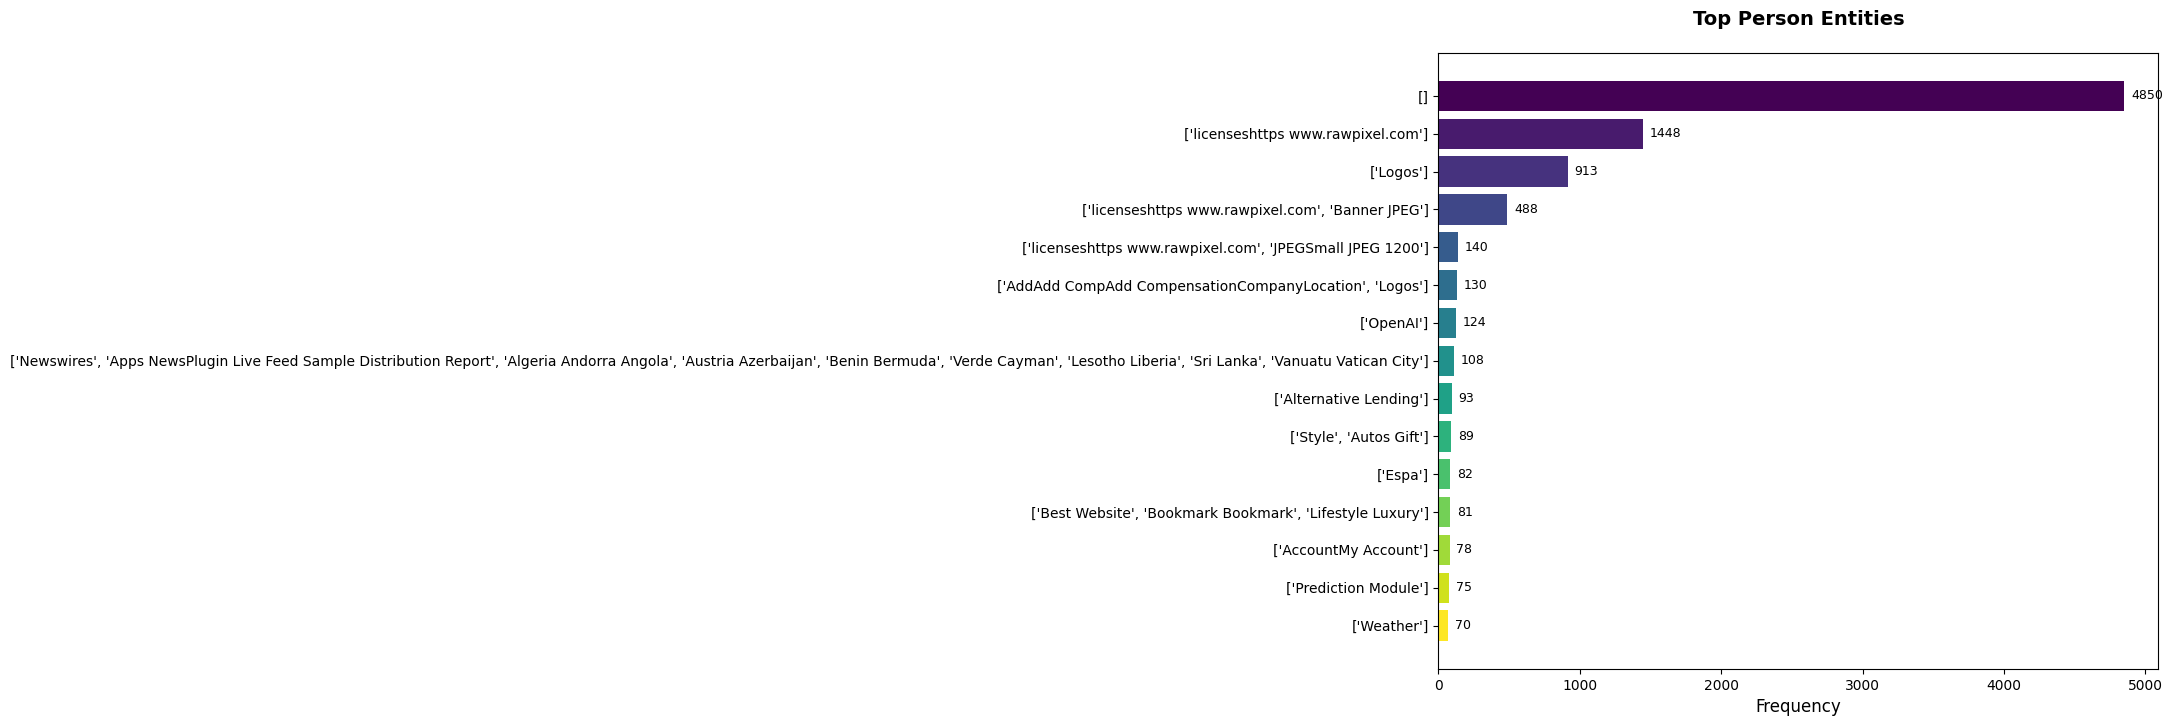

/tmp/ipython-input-4041175831.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


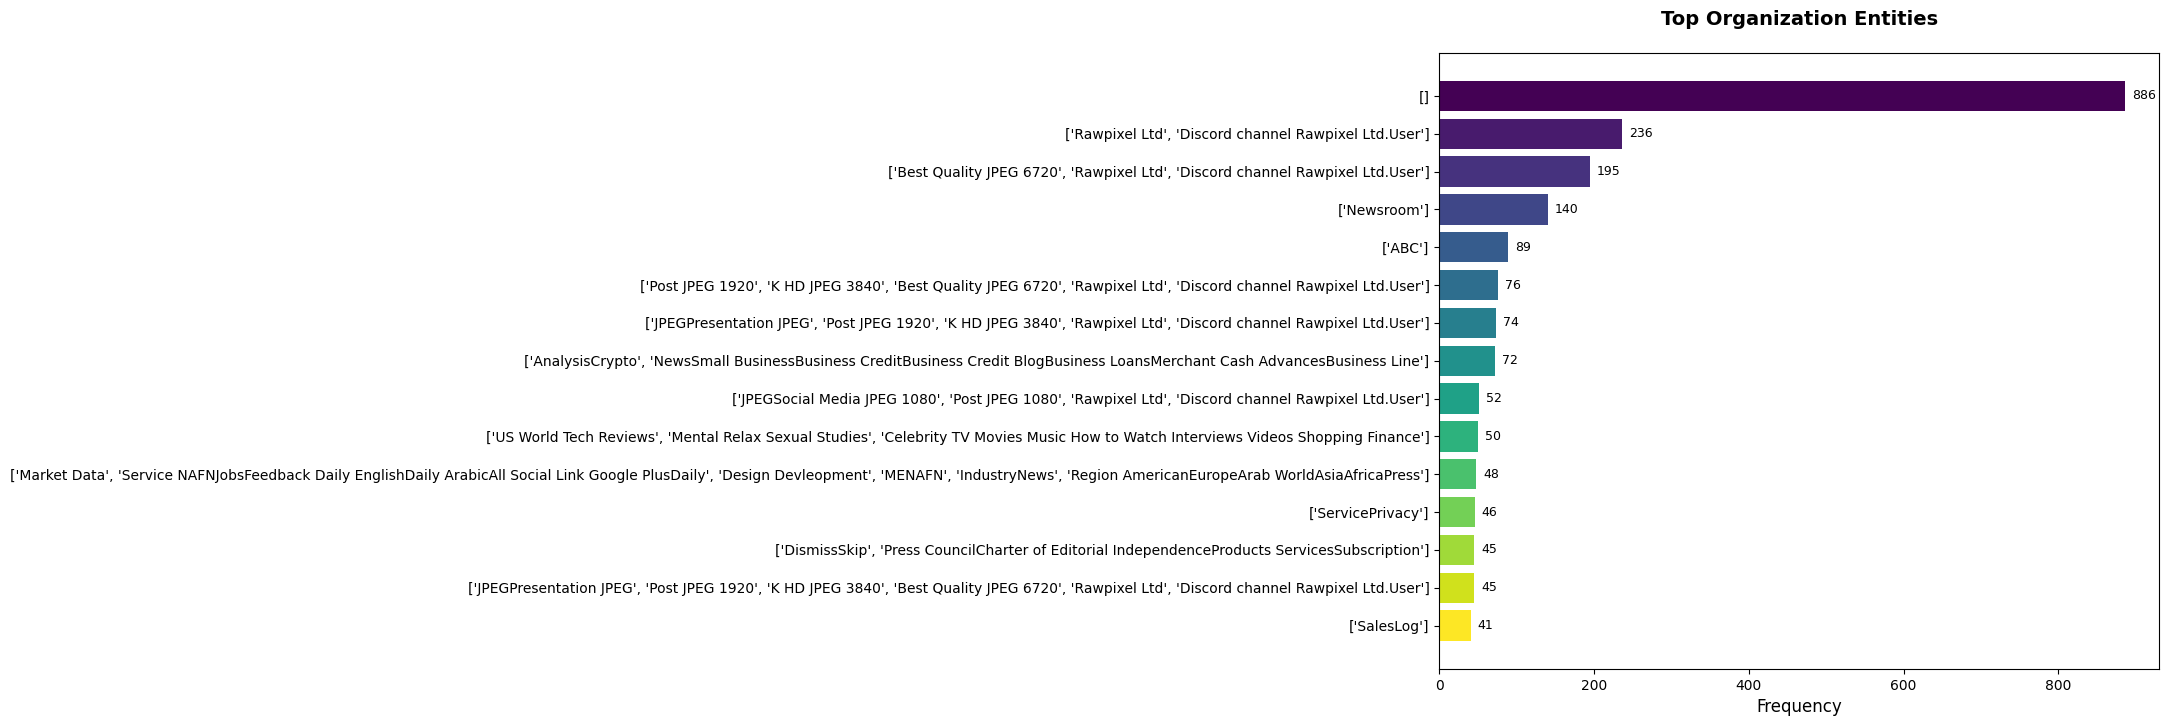

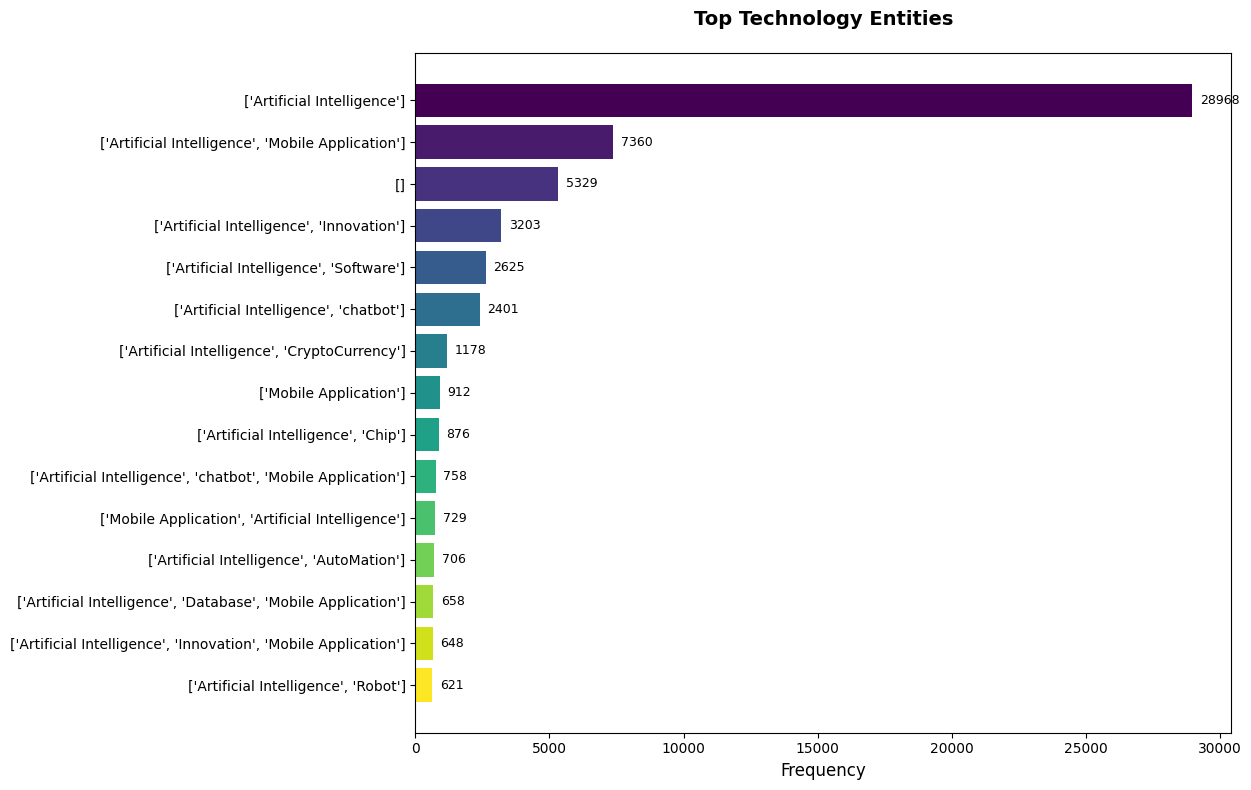

Generating vertical bar charts...


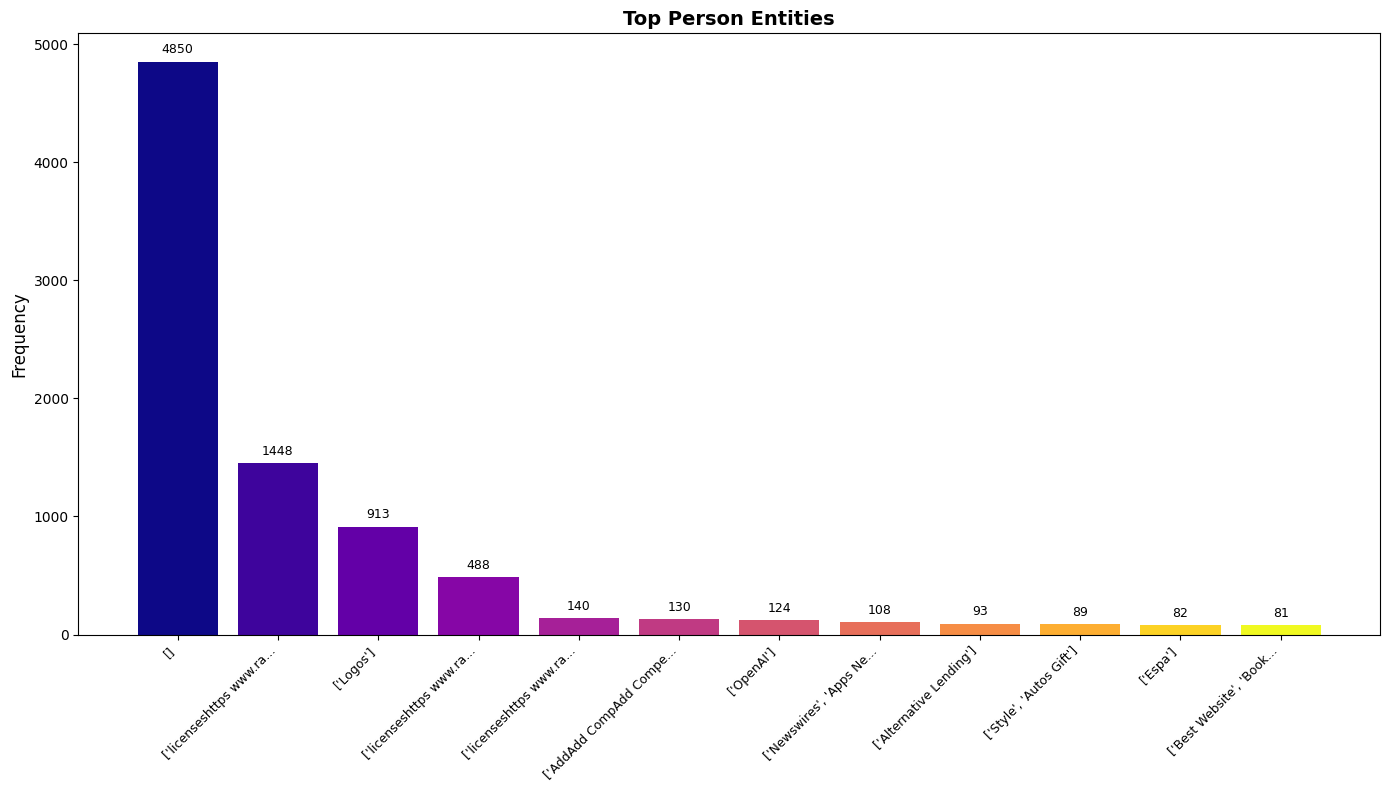

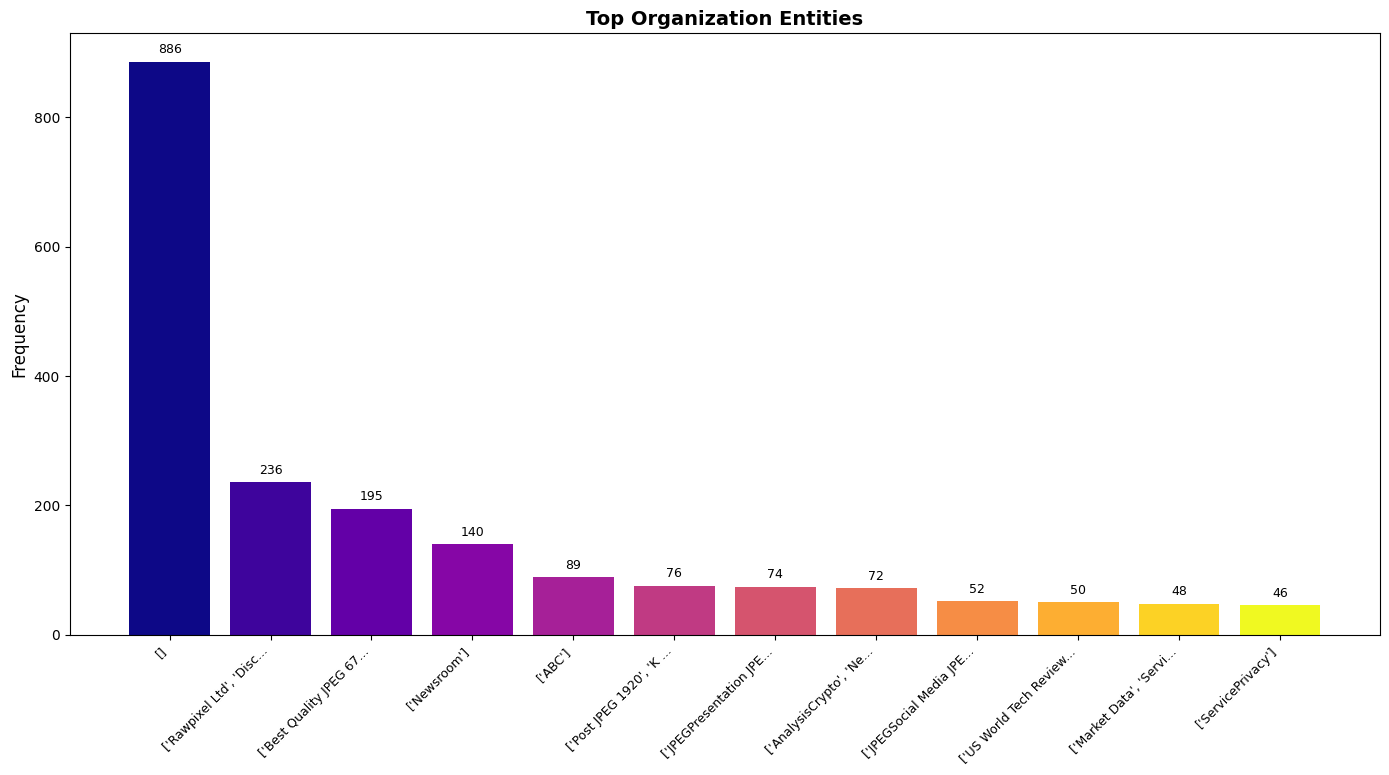

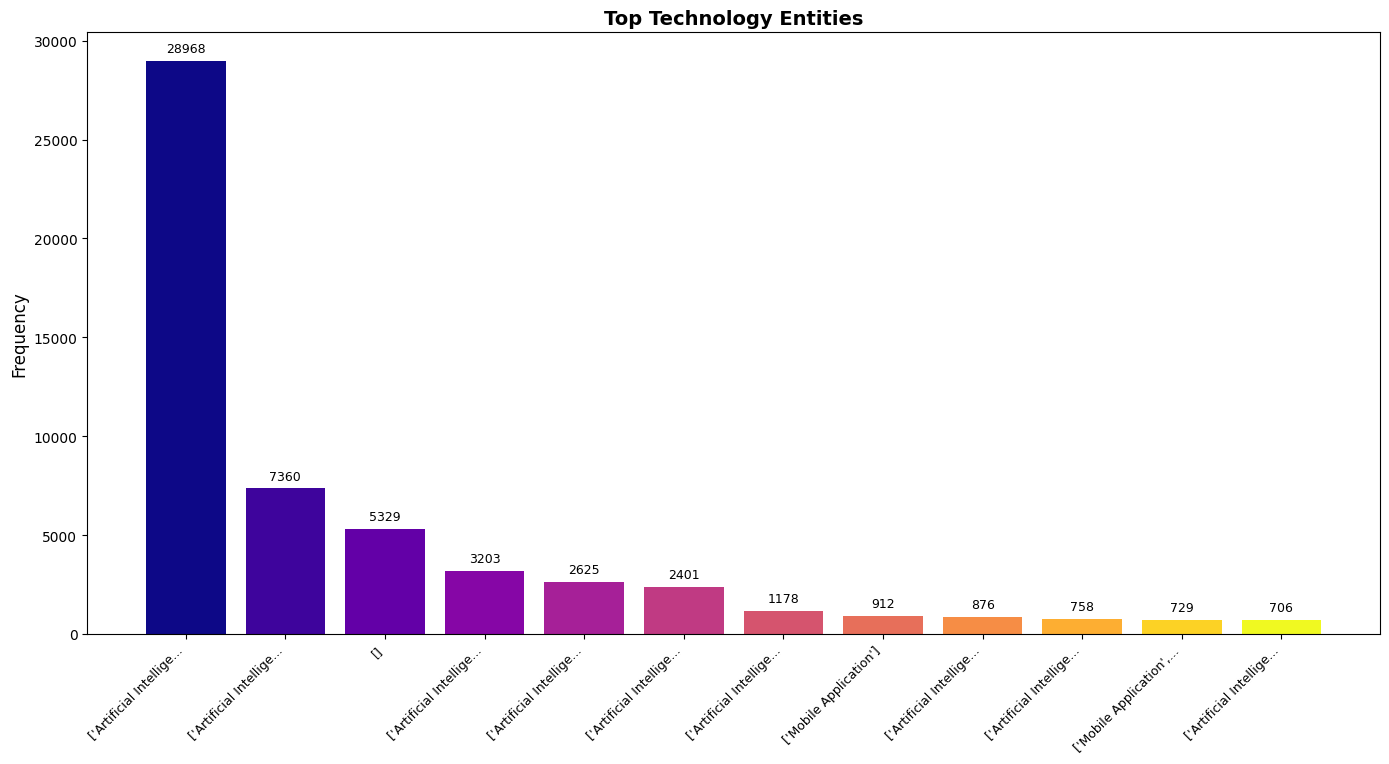

Generating word clouds...


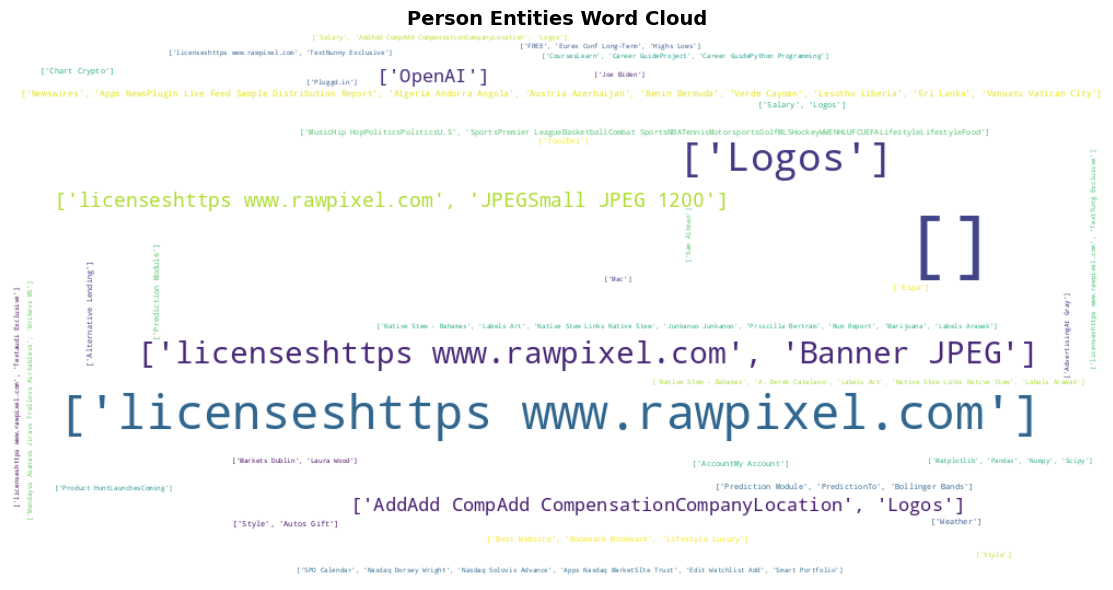

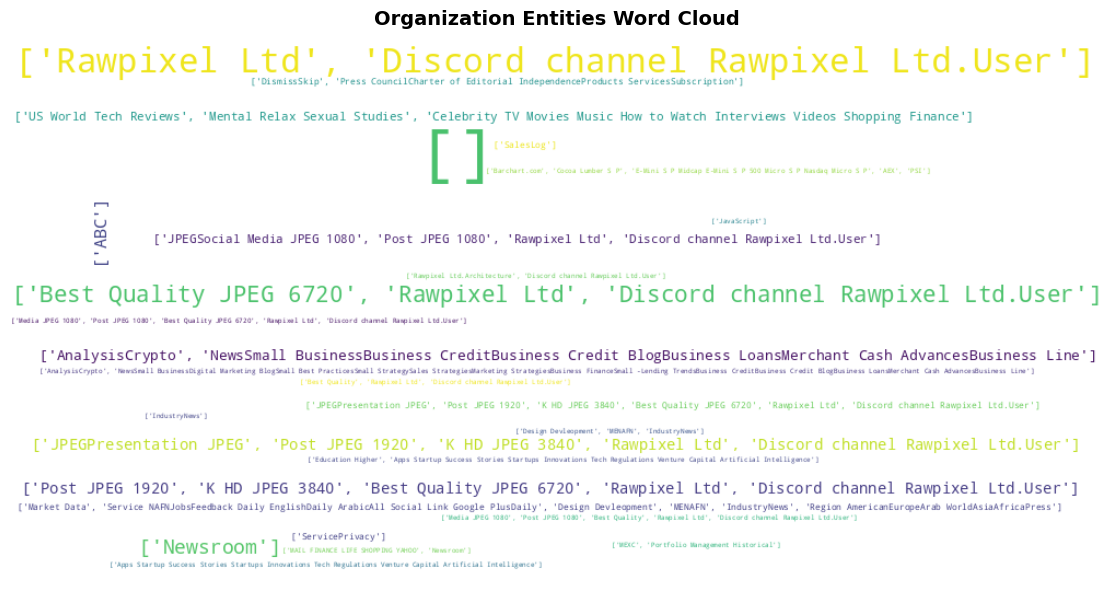

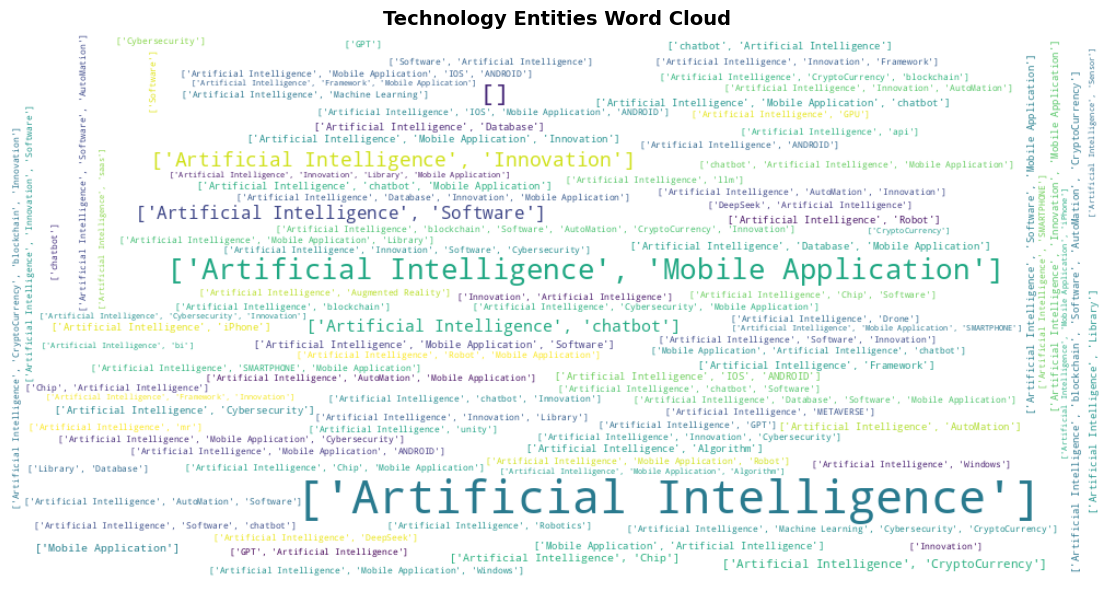

In [ ]:
# Run the visualization
person_counts, org_counts, tech_counts = visualize_all_entities(resolved_df)

# Save the entity counts for further analysis
person_df = pd.DataFrame(person_counts.most_common(), columns=['Entity', 'Count'])
org_df = pd.DataFrame(org_counts.most_common(), columns=['Entity', 'Count'])
tech_df = pd.DataFrame(tech_counts.most_common(), columns=['Entity', 'Count'])

Difficult to identify the right people entities in the new articles, much easier to extract organizations and technologies.